In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/data-aggregation-ipynb/create_feature_train_ver2.pkl
/kaggle/input/data-aggregation-ipynb/create_feature_test_kaggle_ver2.pkl
/kaggle/input/data-aggregation-ipynb/__results__.html
/kaggle/input/data-aggregation-ipynb/__notebook__.ipynb
/kaggle/input/data-aggregation-ipynb/__output__.json
/kaggle/input/data-aggregation-ipynb/custom.css


# Libs

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# Load data

In [3]:
train_full = pd.read_pickle('/kaggle/input/data-aggregation-ipynb/create_feature_train_ver2.pkl')

temp, test = train_test_split(train_full, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209107, 534), (52277, 534), (46127, 534))

In [4]:
train_full.isnull().sum().sum()

54364313

In [5]:
test_kaggle = pd.read_pickle('/kaggle/input/data-aggregation-ipynb/create_feature_test_kaggle_ver2.pkl')
test_kaggle.shape

(48744, 533)

In [6]:
test_kaggle.isnull().sum().sum()

7784556

# Funcs

In [7]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        try:
#     for ivars in ['CARD_M3CARD_IS_DPD_UNDER_120_MEAN']:
            if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
                binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
                d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
            else:
                d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

            # missing
            if d0.isnull().sum().sum() > 0 :
                try:
                    d0['x'] = d0['x'].cat.add_categories('Missing')
                    d0['x'].fillna('Missing', inplace =True)
                except:
    #                 print('var ', ivars)
                    d0['x'].fillna('Missing', inplace =True)


            # Calculate the number of events in each group (bin)
            d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
            d.columns = ['Cutoff', 'N', 'Events']

            # Calculate % of events in each group.
            d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

            # Calculate the non events in each group.
            d['Non-Events'] = d['N'] - d['Events']
            # Calculate % of non events in each group.
            d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

            # Calculate WOE by taking natural log of division of % of non-events and % of events
            d['WoE'] = np.log(d['% of Events']/d['% of Non-Events']) ## ln(good/bad) => event : good
            d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
            d.insert(loc=0, column='Variable', value=ivars)
    #         print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
            temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
            newDF=pd.concat([newDF,temp], axis=0)
            woeDF=pd.concat([woeDF,d], axis=0)
        
        except:
            print('Fail ', ivars)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [8]:
train[['PREV_PREV_CREDIT_APPL_RATIO_MAX', 'PREV_PREV_INTERESTS_RATE_MEAN', 'PREV_D365_PREV_INTERESTS_RATE_MEAN']]

,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_INTERESTS_RATE_MEAN,PREV_D365_PREV_INTERESTS_RATE_MEAN
40022,1.000000,0.005326,NaN
182441,1.198000,NaN,NaN
183176,NaN,NaN,NaN
304480,inf,NaN,NaN
298525,1.110329,0.030384,NaN
...,...,...,...
267366,1.126878,0.008731,0.003383
159110,1.138600,0.019819,0.011544
264768,1.105603,0.008247,0.008247
122424,inf,-inf,NaN


In [9]:
train[['PREV_PREV_CREDIT_APPL_RATIO_MAX',
       'PREV_PREV_INTERESTS_RATE_MEAN', 
       'PREV_D365_PREV_INTERESTS_RATE_MEAN']] = train[['PREV_PREV_CREDIT_APPL_RATIO_MAX',
                                                       'PREV_PREV_INTERESTS_RATE_MEAN', 
                                                       'PREV_D365_PREV_INTERESTS_RATE_MEAN']].replace([np.inf], 99999)

train[['PREV_PREV_CREDIT_APPL_RATIO_MAX', 
       'PREV_PREV_INTERESTS_RATE_MEAN', 
       'PREV_D365_PREV_INTERESTS_RATE_MEAN']] = train[['PREV_PREV_CREDIT_APPL_RATIO_MAX', 
                                                       'PREV_PREV_INTERESTS_RATE_MEAN', 
                                                       'PREV_D365_PREV_INTERESTS_RATE_MEAN']].replace([-np.inf], -99999)


test_kaggle[['PREV_PREV_CREDIT_APPL_RATIO_MAX',
       'PREV_PREV_INTERESTS_RATE_MEAN', 
       'PREV_D365_PREV_INTERESTS_RATE_MEAN']] = test_kaggle[['PREV_PREV_CREDIT_APPL_RATIO_MAX',
                                                       'PREV_PREV_INTERESTS_RATE_MEAN', 
                                                       'PREV_D365_PREV_INTERESTS_RATE_MEAN']].replace([np.inf], 99999)

test_kaggle[['PREV_PREV_CREDIT_APPL_RATIO_MAX', 
       'PREV_PREV_INTERESTS_RATE_MEAN', 
       'PREV_D365_PREV_INTERESTS_RATE_MEAN']] = test_kaggle[['PREV_PREV_CREDIT_APPL_RATIO_MAX', 
                                                       'PREV_PREV_INTERESTS_RATE_MEAN', 
                                                       'PREV_D365_PREV_INTERESTS_RATE_MEAN']].replace([-np.inf], -99999)

In [10]:
train[['PREV_PREV_CREDIT_APPL_RATIO_MAX', 'PREV_PREV_INTERESTS_RATE_MEAN', 'PREV_D365_PREV_INTERESTS_RATE_MEAN']]

,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_INTERESTS_RATE_MEAN,PREV_D365_PREV_INTERESTS_RATE_MEAN
40022,1.000000,0.005326,NaN
182441,1.198000,NaN,NaN
183176,NaN,NaN,NaN
304480,99999.000000,NaN,NaN
298525,1.110329,0.030384,NaN
...,...,...,...
267366,1.126878,0.008731,0.003383
159110,1.138600,0.019819,0.011544
264768,1.105603,0.008247,0.008247
122424,99999.000000,-99999.000000,NaN


In [11]:
newDF, woeDF = iv_woe(data = train.drop(columns = ['SK_ID_CURR']),
                        target = 'TARGET')

In [12]:
newDF

,Variable,IV
0,NAME_CONTRACT_TYPE,0.014715
0,CODE_GENDER,0.036156
0,FLAG_OWN_CAR,0.007192
0,FLAG_OWN_REALTY,0.000601
0,CNT_CHILDREN,0.002109
...,...,...
0,CARD_M3CARD_IS_DPD_SUM,0.005044
0,CARD_M3CARD_IS_DPD_UNDER_120_MEAN,0.006024
0,CARD_M3CARD_IS_DPD_UNDER_120_SUM,0.005895
0,CARD_M3CARD_IS_DPD_OVER_120_MEAN,0.002407


In [13]:
newDF[newDF['IV']>= 0.02]

,Variable,IV
0,CODE_GENDER,0.036156
0,AMT_CREDIT,0.044138
0,AMT_ANNUITY,0.026306
0,AMT_GOODS_PRICE,0.092142
0,NAME_INCOME_TYPE,0.058087
...,...,...
0,CARD_M3CNT_DRAWINGS_CURRENT_MEAN,0.028359
0,CARD_M3CNT_DRAWINGS_CURRENT_SUM,0.027365
0,CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN,0.021785
0,CARD_M3BALANCE_LIMIT_RATIO_MIN,0.062942


In [14]:
woeDF

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,NAME_CONTRACT_TYPE,0,189228,15749.0,0.935214,173479.0,0.902282,0.035848,1.180559e-03
1,NAME_CONTRACT_TYPE,1,19879,1091.0,0.064786,18788.0,0.097718,-0.410996,1.353493e-02
0,CODE_GENDER,0,71490,7184.0,0.426603,64306.0,0.334462,0.243331,2.242089e-02
1,CODE_GENDER,1,137614,9656.0,0.573397,127958.0,0.665522,-0.148995,1.372624e-02
2,CODE_GENDER,2,3,0.0,0.000030,3.0,0.000016,0.643369,9.063718e-06
...,...,...,...,...,...,...,...,...,...
0,CARD_M3CARD_IS_DPD_OVER_120_SUM,0.0,57553,4969.0,0.295071,52584.0,0.273495,0.075935,1.638413e-03
1,CARD_M3CARD_IS_DPD_OVER_120_SUM,1.0,134,9.0,0.000534,125.0,0.000650,-0.195961,2.267187e-05
2,CARD_M3CARD_IS_DPD_OVER_120_SUM,2.0,177,12.0,0.000713,165.0,0.000858,-0.185911,2.706722e-05
3,CARD_M3CARD_IS_DPD_OVER_120_SUM,3.0,108,9.0,0.000534,99.0,0.000515,0.037233,7.272617e-07


In [15]:
# chon bien co IV >= 0.02
woeDF[woeDF['Variable'].isin(newDF[newDF['IV']>= 0.02]['Variable'])]

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CODE_GENDER,0,71490,7184.0,0.426603,64306.0,0.334462,0.243331,0.022421
1,CODE_GENDER,1,137614,9656.0,0.573397,127958.0,0.665522,-0.148995,0.013726
2,CODE_GENDER,2,3,0.0,0.000030,3.0,0.000016,0.643369,0.000009
0,AMT_CREDIT,"(44999.999, 180000.0]",22514,1502.0,0.089192,21012.0,0.109286,-0.203168,0.004082
1,AMT_CREDIT,"(180000.0, 254700.0]",21544,1652.0,0.098100,19892.0,0.103460,-0.053203,0.000285
...,...,...,...,...,...,...,...,...,...
1,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(0.466, 0.891]",4466,349.0,0.020724,4117.0,0.021413,-0.032680,0.000022
2,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(0.891, 0.989]",4467,531.0,0.031532,3936.0,0.020472,0.431970,0.004778
3,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(0.989, 1.035]",4466,716.0,0.042518,3750.0,0.019504,0.779297,0.017934
4,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(1.035, inf]",4467,945.0,0.056116,3522.0,0.018318,1.119529,0.042316


In [16]:
transform_woe_df = woeDF[woeDF['Variable'].isin(newDF[newDF['IV']>= 0.02]['Variable'])]
transform_woe_df.shape

(1961, 9)

In [17]:
transform_woe_df.head()

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CODE_GENDER,0,71490,7184.0,0.426603,64306.0,0.334462,0.243331,0.022421
1,CODE_GENDER,1,137614,9656.0,0.573397,127958.0,0.665522,-0.148995,0.013726
2,CODE_GENDER,2,3,0.0,0.000030,3.0,0.000016,0.643369,0.000009
0,AMT_CREDIT,"(44999.999, 180000.0]",22514,1502.0,0.089192,21012.0,0.109286,-0.203168,0.004082
1,AMT_CREDIT,"(180000.0, 254700.0]",21544,1652.0,0.098100,19892.0,0.103460,-0.053203,0.000285


In [18]:
final_list = list(transform_woe_df['Variable'].unique())
print(len(final_list))
keep_cols = final_list + ['TARGET']
print(len(keep_cols))

228
229


In [19]:
map_transform_dict = {}
for idx in range(transform_woe_df.shape[0]):
    var = transform_woe_df.iloc[idx]['Variable']
    cutoff = transform_woe_df.iloc[idx]['Cutoff']
    woe = float(transform_woe_df.iloc[idx]['WoE'])
    
    if var not in map_transform_dict:
        map_transform_dict[var] = [[], []]  ## cutoff, woe
    if str(cutoff) == 'Missing':
        map_transform_dict[var][0].append('Missing')
    elif '(' not in str(cutoff):
        map_transform_dict[var][0].append(cutoff)
    elif '(' in str(cutoff):
        cutoff_str = str(cutoff).replace('(', '').replace(']', '')
        upper = cutoff_str.split(',')[0]
        lower = cutoff_str.split(',')[-1]
        map_transform_dict[var][0].append([upper, lower])
    map_transform_dict[var][1].append(woe)

In [20]:
from tqdm import tqdm
def map_woe_values(data, map_transform_dict):
    data = data.reset_index().drop(columns = ['index'])
    data_copy = copy.deepcopy(data)
    
    for var in tqdm(map_transform_dict.keys()):
#     for var in ['AMT_CREDIT', 'APPROVED_NEWX2_FLAG_AMT_CREDIT_RATIO_MIN']:
        try:
            cutoff_lst, woe_lst = map_transform_dict[var]
            for idx in range(len(cutoff_lst)):
                cutoff = cutoff_lst[idx]
                woe = woe_lst[idx]
                if type(cutoff) == int:
                    data[var] = data[var].replace({cutoff: woe})

                elif type(cutoff) == str:
                    if str(cutoff) != 'Missing':
                        data[var] = data[var].replace({cutoff: woe})
                    elif str(cutoff) == 'Missing':
                        data[var] = data[var].fillna(woe)
                elif type(cutoff) == float:
                    data[var] = data[var].map({cutoff: woe})

                elif len(cutoff) == 1:
                    if str(cutoff) != 'Missing':
                        data[var] = data[var].map({cutoff: woe})

                elif len(cutoff) == 2:
                    upper = float(cutoff[0])
                    lower = float(cutoff[-1])
                    index_ = data_copy[(data_copy[var]> upper)&
                                       (data_copy[var]<= lower)].index
                    data.iloc[index_, data.columns.get_loc(var)] = woe
        except:
            print('FAIL ', var)
                
    return data, data_copy

In [21]:
train_w = train[keep_cols].reset_index().drop(columns = ['index'])
train_temp = copy.deepcopy(train_w)
train_map, train_copy = map_woe_values(data = train_temp, map_transform_dict = map_transform_dict)
train_map.head()

100%|██████████| 228/228 [00:26<00:00,  8.60it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CARD_M3AMT_TOTAL_RECEIVABLE_MEAN,CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX,CARD_M3CNT_DRAWINGS_ATM_CURRENT_SUM,CARD_M3CNT_DRAWINGS_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MEAN,CARD_M3CNT_DRAWINGS_CURRENT_SUM,CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN,CARD_M3BALANCE_LIMIT_RATIO_MIN,CARD_M3BALANCE_LIMIT_RATIO_MAX,TARGET
0,-0.148995,-0.440929,-0.054495,-0.535892,0.186927,-0.426814,0.043388,-0.046570,0.224276,-0.336344,...,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402,0.0
1,0.243331,-0.053203,0.039243,0.087040,0.186927,0.109468,0.230408,-0.144287,-0.154163,0.190582,...,-0.217207,-0.065527,-0.014616,-0.083794,-0.095585,-0.088569,-0.065527,-0.301292,-0.370609,0.0
2,-0.148995,-0.138356,0.125151,0.042709,-0.073939,-0.426814,0.215902,-0.605957,0.103000,0.023608,...,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402,0.0
3,-0.148995,-0.440929,-0.353997,-0.535892,-0.073939,0.109468,-0.076393,0.064697,0.103000,0.279253,...,-0.217207,0.126867,-0.014616,-0.083794,-0.095585,-0.088569,0.145638,-0.301292,-0.370609,0.0
4,0.243331,0.280263,0.039243,-0.248066,0.186927,0.109468,-0.076393,0.013718,-0.265192,-0.131730,...,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402,0.0


In [22]:
valid_w = valid[keep_cols].reset_index().drop(columns = ['index'])
valid_temp = copy.deepcopy(valid_w)
valid_map, valid_copy = map_woe_values(data = valid_temp, map_transform_dict = map_transform_dict)
valid_map.head()

100%|██████████| 228/228 [00:08<00:00, 28.21it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CARD_M3AMT_TOTAL_RECEIVABLE_MEAN,CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX,CARD_M3CNT_DRAWINGS_ATM_CURRENT_SUM,CARD_M3CNT_DRAWINGS_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MEAN,CARD_M3CNT_DRAWINGS_CURRENT_SUM,CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN,CARD_M3BALANCE_LIMIT_RATIO_MIN,CARD_M3BALANCE_LIMIT_RATIO_MAX,TARGET
0,-0.148995,0.054611,0.039243,0.042709,0.186927,-0.426814,0.043388,0.013718,0.347810,0.372594,...,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402,0.0
1,0.243331,-0.150041,0.239540,-0.192022,-0.073939,0.109468,-0.076393,0.184204,-0.052945,-0.336344,...,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402,1.0
2,-0.148995,-0.138356,0.239540,-0.192022,0.186927,0.109468,-0.076393,0.013718,0.103000,0.279253,...,-0.217207,0.126867,-0.014616,-0.083794,-0.095585,-0.088569,0.145638,-0.301292,-0.370609,1.0
3,0.243331,0.249411,0.039243,0.261809,0.186927,0.109468,-0.076393,-0.046570,-0.052945,0.023608,...,0.557441,0.897375,0.791270,0.645000,0.639811,0.644845,0.555891,0.661537,1.119529,0.0
4,-0.148995,-0.203168,-0.152308,-0.110534,0.186927,0.109468,0.230408,-0.144287,-0.265192,-0.336344,...,-0.217207,-0.065527,-0.014616,-0.083794,-0.095585,-0.088569,-0.065527,-0.301292,-0.370609,0.0


In [23]:
test_w = test[keep_cols].reset_index().drop(columns = ['index'])
test_temp = copy.deepcopy(test_w)
test_map, test_copy = map_woe_values(data = test_temp, map_transform_dict = map_transform_dict)
test_map.head()

100%|██████████| 228/228 [00:07<00:00, 31.21it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CARD_M3AMT_TOTAL_RECEIVABLE_MEAN,CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX,CARD_M3CNT_DRAWINGS_ATM_CURRENT_SUM,CARD_M3CNT_DRAWINGS_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MEAN,CARD_M3CNT_DRAWINGS_CURRENT_SUM,CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN,CARD_M3BALANCE_LIMIT_RATIO_MIN,CARD_M3BALANCE_LIMIT_RATIO_MAX,TARGET
0,-0.148995,-0.203168,-0.152308,-0.110534,0.186927,-0.426814,-0.076393,0.064697,0.402118,0.190582,...,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402,0.0
1,-0.148995,0.054611,-0.353997,0.042709,-0.073939,0.032517,-0.076393,-0.605957,0.347810,0.190582,...,-0.217207,-0.065527,-0.014616,-0.083794,-0.095585,-0.088569,-0.065527,-0.301292,-0.370609,0.0
2,-0.148995,-0.150041,0.239540,-0.535892,-0.373258,-0.426814,-0.076393,-0.009331,0.347810,0.190582,...,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402,0.0
3,-0.148995,-0.138356,0.065583,-0.192022,0.186927,-0.426814,-0.346184,0.013718,-0.052945,0.393778,...,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402,0.0
4,-0.148995,0.054611,-0.353997,0.042709,-0.433923,0.109468,0.215902,-0.009331,-0.534407,-0.337003,...,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402,0.0


In [24]:
test_kaggle_w = test_kaggle[final_list].reset_index().drop(columns = ['index'])
test_kaggle_w_temp = copy.deepcopy(test_kaggle_w)
test_kaggle_map, test_kaggle_copy = map_woe_values(data = test_kaggle_w_temp, map_transform_dict = map_transform_dict)
test_kaggle_map.head()

100%|██████████| 228/228 [00:07<00:00, 28.61it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CARD_M3AMT_TOTAL_RECEIVABLE_MAX,CARD_M3AMT_TOTAL_RECEIVABLE_MEAN,CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX,CARD_M3CNT_DRAWINGS_ATM_CURRENT_SUM,CARD_M3CNT_DRAWINGS_CURRENT_MAX,CARD_M3CNT_DRAWINGS_CURRENT_MEAN,CARD_M3CNT_DRAWINGS_CURRENT_SUM,CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN,CARD_M3BALANCE_LIMIT_RATIO_MIN,CARD_M3BALANCE_LIMIT_RATIO_MAX
0,-0.148995,0.280263,0.102726,0.557223,0.186927,-0.426814,-0.076393,0.184204,-0.265192,0.023608,...,-0.029891,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402
1,0.243331,-0.053203,0.053719,-0.110534,0.186927,0.109468,-0.076393,-0.144287,-0.154163,-0.336344,...,-0.029891,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402
2,0.243331,0.054611,-0.353997,0.042709,0.186927,-0.426814,-0.076393,0.184204,-0.265192,-0.336344,...,-0.218008,-0.217207,0.126867,-0.014616,-0.083794,-0.095585,-0.088569,0.145638,-0.301292,-0.370609
3,-0.148995,-0.440929,-0.353997,-0.535892,0.186927,0.109468,-0.076393,-0.086609,0.103000,0.023608,...,-0.218008,-0.217207,0.126867,-0.014616,0.645000,0.639811,0.644845,0.555891,-0.301292,-0.370609
4,0.243331,0.054611,0.065583,0.042709,0.186927,0.109468,-0.076393,-0.046570,0.224276,0.023608,...,-0.029891,-0.029891,-0.065527,-0.029891,-0.029891,-0.029891,-0.029891,-0.065527,-0.039402,-0.039402


In [25]:
train_map.to_pickle('train_w_woe_trans.pkl')
valid_map.to_pickle('valid_w_woe_trans.pkl')
test_map.to_pickle('test_w_woe_trans.pkl')
test_kaggle_map.to_pickle('test_kaggle_woe_trans.pkl')

# Backward selection

In [26]:
import pandas as pd
import statsmodels.api as sm

In [27]:
train_map_w = train_map[np.isfinite(train_map).all(1)]
valid_map_w = valid_map[np.isfinite(valid_map).all(1)]
test_map_w  = test_map[np.isfinite(test_map).all(1)]

In [28]:
def backward_regression(X, y,
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {} with p-value = {}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

included = backward_regression(train_map_w.drop(columns = ['TARGET']), train_map_w['TARGET'])

Drop INS_D365AMT_DIFF_MEAN with p-value = 0.9973979233976689
Drop NONLIVINGAREA_MODE with p-value = 0.9944612384610534
Drop INS_AMT_DIFF_MAX with p-value = 0.984788040710697
Drop FLOORSMAX_MEDI with p-value = 0.9818791438745125
Drop INS_AMT_PAYMENT_MAX with p-value = 0.9796147006235063
Drop CARD_M3AMT_DRAWINGS_POS_CURRENT_SUM with p-value = 0.9788443873593817
Drop INS_AMT_DIFF_SUM with p-value = 0.9701618179368469
Drop LIVINGAREA_MEDI with p-value = 0.9634175144556834
Drop ELEVATORS_MODE with p-value = 0.9598274636695321
Drop HOUSETYPE_MODE with p-value = 0.9474085791895221
Drop INS_D365AMT_DIFF_MAX with p-value = 0.9465305884607024
Drop INS_D365AMT_DIFF_SUM with p-value = 0.9400800005977136
Drop BUREAU_BUREAU_CREDIT_DEBT_DIFF_MAX with p-value = 0.9126141305821757
Drop PREV_D365_CNT_PAYMENT_SUM with p-value = 0.9110745716925933
Drop APARTMENTS_MEDI with p-value = 0.8914146871170072
Drop INS_DAYS_ENTRY_PAYMENT_MEAN with p-value = 0.8908533976680945
Drop YEARS_BEGINEXPLUATATION_MODE with

In [29]:
len(included), included

(104,
 ['CODE_GENDER',
  'AMT_ANNUITY',
  'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPE',
  'NAME_FAMILY_STATUS',
  'DAYS_BIRTH',
  'DAYS_ID_PUBLISH',
  'OWN_CAR_AGE',
  'FLAG_EMP_PHONE',
  'REGION_RATING_CLIENT_W_CITY',
  'REG_CITY_NOT_LIVE_CITY',
  'ORGANIZATION_TYPE',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'FLOORSMIN_AVG',
  'YEARS_BEGINEXPLUATATION_MEDI',
  'ELEVATORS_MEDI',
  'ENTRANCES_MEDI',
  'FLOORSMIN_MEDI',
  'FLAG_DOCUMENT_3',
  'APPS_EXT_SOURCE_MEAN',
  'APPS_EXT_SOURCE_STD',
  'APPS_ANNUITY_CREDIT_RATIO',
  'APPS_GOODS_CREDIT_RATIO',
  'APPS_EMPLOYED_BIRTH_RATIO',
  'APPS_INCOME_EMPLOYED_RATIO',
  'APPS_INCOME_BIRTH_RATIO',
  'PREV_AMT_ANNUITY_MEAN',
  'PREV_AMT_DOWN_PAYMENT_MEAN',
  'PREV_AMT_DOWN_PAYMENT_MAX',
  'PREV_AMT_DOWN_PAYMENT_SUM',
  'PREV_RATE_DOWN_PAYMENT_MAX',
  'PREV_DAYS_DECISION_MEAN',
  'PREV_CNT_PAYMENT_MEAN',
  'PREV_PREV_CREDIT_DIFF_MEAN',
  'PREV_PREV_CREDIT_DIFF_SUM',
  'PREV_PREV_CREDIT_APPL_RATIO_MEAN',
  'PREV_PREV_DAYS_LAST_DUE_DIF

In [30]:
import pandas as pd
import statsmodels.api as sm

def forward_regression(X, y,
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
#         print('excluded ', len(excluded))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
#             print('new column ', new_column)
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add {} with p-value {}'.format(best_feature, best_pval))

        if not changed:
            break

    return included


included2 = forward_regression(train_map_w[included], train_map_w['TARGET'])

Add BUREAU_BUREAU_IS_DPD_SUM with p-value 0.0
Add EXT_SOURCE_2 with p-value 0.0
Add EXT_SOURCE_3 with p-value 0.0
Add EXT_SOURCE_1 with p-value 2.4300827193109824e-210
Add CARD_M3BALANCE_LIMIT_RATIO_MAX with p-value 3.351524758216374e-173
Add APPS_GOODS_CREDIT_RATIO with p-value 2.4421569921706975e-146
Add BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y with p-value 4.4379989550995056e-129
Add INS_D365SK_DPD_MAX with p-value 3.728161509512486e-107
Add APPS_EMPLOYED_BIRTH_RATIO with p-value 9.854069340400455e-97
Add INS_AMT_PAYMENT_SUM with p-value 2.3386009490049986e-79
Add PREV_REFUSED_RATIO with p-value 1.6686569010452646e-73
Add PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN with p-value 3.1443638641179876e-61
Add APPS_ANNUITY_CREDIT_RATIO with p-value 1.7750166019228168e-56
Add CODE_GENDER with p-value 5.980304771661944e-46
Add PREV_PREV_CREDIT_APPL_RATIO_MEAN with p-value 8.026163650768329e-45
Add FLAG_DOCUMENT_3 with p-value 3.980340754543835e-36
Add NAME_EDUCATION_TYPE with p-value 1.5442829330644

In [31]:
len(included2), included2

(75,
 ['BUREAU_BUREAU_IS_DPD_SUM',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'EXT_SOURCE_1',
  'CARD_M3BALANCE_LIMIT_RATIO_MAX',
  'APPS_GOODS_CREDIT_RATIO',
  'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y',
  'INS_D365SK_DPD_MAX',
  'APPS_EMPLOYED_BIRTH_RATIO',
  'INS_AMT_PAYMENT_SUM',
  'PREV_REFUSED_RATIO',
  'PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN',
  'APPS_ANNUITY_CREDIT_RATIO',
  'CODE_GENDER',
  'PREV_PREV_CREDIT_APPL_RATIO_MEAN',
  'FLAG_DOCUMENT_3',
  'NAME_EDUCATION_TYPE',
  'APPS_EXT_SOURCE_MEAN',
  'PREV_PREV_INTERESTS_RATE_MEAN',
  'OWN_CAR_AGE',
  'INS_INS_IS_DPD_UNDER_120_MEAN',
  'PREV_D365_PREV_CREDIT_APPL_RATIO_MAX',
  'INS_INS_IS_DPD_SUM',
  'REG_CITY_NOT_LIVE_CITY',
  'BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN',
  'PREV_D365_PREV_INTERESTS_RATE_MAX',
  'BUREAU_ACT_AMT_CREDIT_SUM_DEBT_MEAN_y',
  'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN',
  'BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MEAN_y',
  'CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX',
  'APPS_INCOME_BIRTH_RATIO',
  'BUREAU_AMT_CREDIT_SUM_MAX',
  'BUR

In [32]:
include1 = ['CODE_GENDER',
  'AMT_ANNUITY',
  'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPE',
  'DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'DAYS_ID_PUBLISH',
  'OWN_CAR_AGE',
  'FLAG_EMP_PHONE',
  'OCCUPATION_TYPE',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'REG_CITY_NOT_LIVE_CITY',
  'ORGANIZATION_TYPE',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'ELEVATORS_MODE',
  'YEARS_BEGINEXPLUATATION_MEDI',
  'ENTRANCES_MEDI',
  'HOUSETYPE_MODE',
  'WALLSMATERIAL_MODE',
  'FLAG_DOCUMENT_3',
  'APPS_EXT_SOURCE_MEAN',
  'APPS_EXT_SOURCE_STD',
  'APPS_ANNUITY_CREDIT_RATIO',
  'APPS_GOODS_CREDIT_RATIO',
  'APPS_INCOME_EMPLOYED_RATIO',
  'APPS_INCOME_BIRTH_RATIO',
  'PREV_AMT_DOWN_PAYMENT_MEAN',
  'PREV_DAYS_DECISION_MEAN',
  'PREV_CNT_PAYMENT_MEAN',
  'PREV_PREV_CREDIT_DIFF_MEAN',
  'PREV_PREV_CREDIT_DIFF_SUM',
  'PREV_PREV_CREDIT_APPL_RATIO_MEAN',
  'PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN',
  'PREV_PREV_DAYS_LAST_DUE_DIFF_SUM',
  'PREV_PREV_INTERESTS_RATE_MEAN',
  'PREV_PREV_INTERESTS_RATE_MAX',
  'PREV_D365_CNT_PAYMENT_MEAN',
  'PREV_D365_PREV_CREDIT_DIFF_SUM',
  'PREV_D365_PREV_CREDIT_APPL_RATIO_MEAN',
  'PREV_D365_PREV_CREDIT_APPL_RATIO_MAX',
  'PREV_D365_PREV_INTERESTS_RATE_MAX',
  'PREV_REFUSED_RATIO',
  'PREV_APPROVED_RATIO',
  'BUREAU_DAYS_CREDIT_MAX',
  'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
  'BUREAU_DAYS_CREDIT_ENDDATE_MEAN',
  'BUREAU_DAYS_ENDDATE_FACT_MAX',
  'BUREAU_DAYS_ENDDATE_FACT_MEAN',
  'BUREAU_AMT_CREDIT_SUM_MAX',
  'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
  'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
  'BUREAU_BUREAU_CREDIT_FACT_DIFF_MAX',
  'BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MAX',
  'BUREAU_BUREAU_CREDIT_ENDDATE_DIFF_MEAN',
  'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN',
  'BUREAU_BUREAU_CREDIT_DEBT_DIFF_MIN',
  'BUREAU_BUREAU_CREDIT_DEBT_DIFF_MEAN',
  'BUREAU_BUREAU_IS_DPD_SUM',
  'BUREAU_ACT_SK_ID_BUREAU_COUNT_x',
  'BUREAU_ACT_DAYS_CREDIT_MAX_x',
  'BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MAX_x',
  'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MIN_x',
  'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x',
  'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MEAN_x',
  'BUREAU_ACT_SK_ID_BUREAU_COUNT_y',
  'BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MEAN_y',
  'BUREAU_ACT_AMT_CREDIT_SUM_DEBT_MEAN_y',
  'BUREAU_ACT_AMT_CREDIT_SUM_DEBT_SUM_y',
  'BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MEAN_y',
  'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y',
  'POS_SK_ID_CURR_COUNT',
  'POS_MONTHS_BALANCE_MIN',
  'INS_DAYS_ENTRY_PAYMENT_SUM',
  'INS_DAYS_INSTALMENT_SUM',
  'INS_AMT_INSTALMENT_MEAN',
  'INS_AMT_INSTALMENT_MAX',
  'INS_AMT_PAYMENT_MEAN',
  'INS_AMT_PAYMENT_SUM',
  'INS_SK_DPD_MEAN',
  'INS_INS_IS_DPD_SUM',
  'INS_INS_IS_DPD_UNDER_120_MEAN',
  'INS_INS_IS_DPD_UNDER_120_SUM',
  'INS_D365AMT_RATIO_MEAN',
  'INS_D365SK_DPD_MEAN',
  'INS_D365SK_DPD_MAX',
  'CARD_AMT_INST_MIN_REGULARITY_MEAN',
  'CARD_CNT_DRAWINGS_ATM_CURRENT_SUM',
  'CARD_CNT_DRAWINGS_CURRENT_MAX',
  'CARD_CNT_DRAWINGS_CURRENT_SUM',
  'CARD_CNT_DRAWINGS_POS_CURRENT_MEAN',
  'CARD_BALANCE_LIMIT_RATIO_MAX',
  'CARD_M3AMT_TOTAL_RECEIVABLE_MAX',
  'CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX',
  'CARD_M3CNT_DRAWINGS_CURRENT_SUM',
  'CARD_M3CNT_DRAWINGS_POS_CURRENT_MEAN',
  'CARD_M3BALANCE_LIMIT_RATIO_MAX']


include2 = ['APPS_EXT_SOURCE_MEAN',
  'BUREAU_BUREAU_IS_DPD_SUM',
  'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y',
  'INS_D365SK_DPD_MAX',
  'APPS_GOODS_CREDIT_RATIO',
  'CARD_M3BALANCE_LIMIT_RATIO_MAX',
  'DAYS_EMPLOYED',
  'PREV_REFUSED_RATIO',
  'POS_SK_ID_CURR_COUNT',
  'NAME_EDUCATION_TYPE',
  'PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN',
  'APPS_ANNUITY_CREDIT_RATIO',
  'CODE_GENDER',
  'FLAG_DOCUMENT_3',
  'BUREAU_AMT_CREDIT_SUM_MAX',
  'PREV_D365_PREV_CREDIT_APPL_RATIO_MAX',
  'INS_INS_IS_DPD_UNDER_120_MEAN',
  'PREV_AMT_DOWN_PAYMENT_MEAN',
  'REG_CITY_NOT_LIVE_CITY',
  'OWN_CAR_AGE',
  'EXT_SOURCE_3',
  'EXT_SOURCE_2',
  'EXT_SOURCE_1',
  'PREV_PREV_INTERESTS_RATE_MEAN',
  'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x',
  'PREV_PREV_DAYS_LAST_DUE_DIFF_SUM',
  'INS_AMT_PAYMENT_SUM',
  'PREV_D365_PREV_INTERESTS_RATE_MAX',
  'REGION_RATING_CLIENT_W_CITY',
  'APPS_INCOME_BIRTH_RATIO',
  'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
  'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN',
  'BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MAX_x',
  'OCCUPATION_TYPE',
  'BUREAU_ACT_SK_ID_BUREAU_COUNT_y',
  'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MIN_x',
  'PREV_PREV_CREDIT_APPL_RATIO_MEAN',
  'DAYS_ID_PUBLISH',
  'DAYS_BIRTH',
  'NAME_INCOME_TYPE',
  'FLAG_EMP_PHONE',
  'ORGANIZATION_TYPE',
  'BUREAU_ACT_AMT_CREDIT_SUM_DEBT_MEAN_y',
  'BUREAU_ACT_BUREAU_CREDIT_ENDDATE_DIFF_MEAN_y',
  'PREV_PREV_CREDIT_DIFF_MEAN',
  'CARD_M3CNT_DRAWINGS_ATM_CURRENT_MAX',
  'INS_INS_IS_DPD_SUM',
  'PREV_PREV_INTERESTS_RATE_MAX',
  'WALLSMATERIAL_MODE',
  'APPS_INCOME_EMPLOYED_RATIO',
  'AMT_ANNUITY',
  'INS_AMT_INSTALMENT_MAX',
  'INS_D365AMT_RATIO_MEAN',
  'CARD_M3AMT_TOTAL_RECEIVABLE_MAX',
  'PREV_CNT_PAYMENT_MEAN',
  'BUREAU_BUREAU_CREDIT_FACT_DIFF_MAX',
  'APPS_EXT_SOURCE_STD',
  'BUREAU_ACT_SK_ID_BUREAU_COUNT_x',
  'PREV_D365_PREV_CREDIT_APPL_RATIO_MEAN',
  'BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MEAN_y',
  'PREV_D365_PREV_CREDIT_DIFF_SUM',
  'PREV_PREV_CREDIT_DIFF_SUM',
  'CARD_CNT_DRAWINGS_CURRENT_MAX',
  'INS_INS_IS_DPD_UNDER_120_SUM']

In [33]:
train_temp = pd.read_pickle('/kaggle/input/data-aggregation-ipynb/create_feature_train_ver2.pkl')

In [34]:
include_iv = include2 + ['TARGET']
newDF_include2, woeDF_include2 = iv_woe(data = train_temp[include_iv],
                        target = 'TARGET')

Fail  PREV_PREV_INTERESTS_RATE_MEAN


In [35]:
newDF_include2.sort_values(by = ['IV'], ascending = False).head(20)

,Variable,IV
0,APPS_EXT_SOURCE_MEAN,0.608221
0,EXT_SOURCE_3,0.329443
0,EXT_SOURCE_2,0.306386
0,EXT_SOURCE_1,0.150901
0,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,0.138003
0,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,0.127823
0,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,0.124962
0,DAYS_EMPLOYED,0.101263
0,APPS_ANNUITY_CREDIT_RATIO,0.093505
0,DAYS_BIRTH,0.084200


In [36]:
logit_vars = newDF_include2.sort_values(by = ['IV'], ascending = False).head(30)['Variable'].to_list()
logit_vars

['APPS_EXT_SOURCE_MEAN',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y',
 'DAYS_EMPLOYED',
 'APPS_ANNUITY_CREDIT_RATIO',
 'DAYS_BIRTH',
 'CARD_M3BALANCE_LIMIT_RATIO_MAX',
 'INS_D365SK_DPD_MAX',
 'APPS_INCOME_EMPLOYED_RATIO',
 'APPS_GOODS_CREDIT_RATIO',
 'PREV_REFUSED_RATIO',
 'INS_INS_IS_DPD_UNDER_120_MEAN',
 'NAME_INCOME_TYPE',
 'INS_D365AMT_RATIO_MEAN',
 'PREV_D365_PREV_INTERESTS_RATE_MAX',
 'REGION_RATING_CLIENT_W_CITY',
 'PREV_PREV_CREDIT_APPL_RATIO_MEAN',
 'NAME_EDUCATION_TYPE',
 'CARD_CNT_DRAWINGS_CURRENT_MAX',
 'CARD_M3AMT_TOTAL_RECEIVABLE_MAX',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
 'BUREAU_BUREAU_CREDIT_FACT_DIFF_MAX',
 'PREV_D365_PREV_CREDIT_APPL_RATIO_MAX',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MIN_x',
 'PREV_PREV_INTERESTS_RATE_MAX',
 'CODE_GENDER']

In [37]:
logit_var_logic_trend = ['APPS_EXT_SOURCE_MEAN',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y',
 'DAYS_BIRTH',
 'CARD_M3BALANCE_LIMIT_RATIO_MAX',
 'INS_D365SK_DPD_MAX',
 'APPS_INCOME_EMPLOYED_RATIO',
 'APPS_GOODS_CREDIT_RATIO',
 'PREV_REFUSED_RATIO',
 'INS_INS_IS_DPD_UNDER_120_MEAN',
 'INS_D365AMT_RATIO_MEAN',
 'REGION_RATING_CLIENT_W_CITY',
 'PREV_PREV_CREDIT_APPL_RATIO_MEAN',
 'NAME_EDUCATION_TYPE',
 'CARD_CNT_DRAWINGS_CURRENT_MAX',
 'CARD_M3AMT_TOTAL_RECEIVABLE_MAX',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
 'BUREAU_BUREAU_CREDIT_FACT_DIFF_MAX',
 'PREV_D365_PREV_CREDIT_APPL_RATIO_MAX']

In [38]:
log_reg_sm = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg_sm.fit(train_map_w[logit_var_logic_trend], train_map_w['TARGET'])

LogisticRegression(C=0.0001)

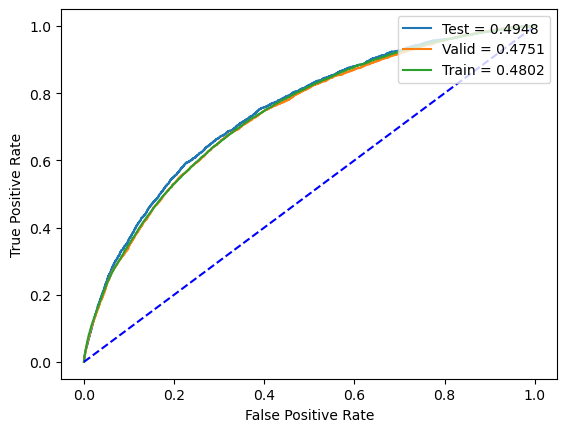

In [39]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=1)
    

pred_test = log_reg_sm.predict_proba(test_map_w[logit_var_logic_trend])[:, 1]
pred_valid = log_reg_sm.predict_proba(valid_map_w[logit_var_logic_trend])[:, 1]
pred_train = log_reg_sm.predict_proba(train_map_w[logit_var_logic_trend])[:, 1]

plot_roc_curve(true_y = (test_map_w['TARGET'], valid_map_w['TARGET'], train_map_w['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [40]:
log_reg_sm.coef_

array([[0.34641004, 0.20388702, 0.17646604, 0.10349585, 0.09665826,
        0.0956286 , 0.09149855, 0.06121557, 0.07004004, 0.08041867,
        0.07161726, 0.08135689, 0.06587767, 0.06647768, 0.00036285,
        0.0370322 , 0.05635652, 0.05235768, 0.03988822, 0.03579684,
        0.02074229, 0.0345053 , 0.04935554]])

In [41]:
idx_lst = [num for num in log_reg_sm.coef_[0] if num < 0]
idx_lst

[]

In [42]:
log_reg_sm.intercept_

array([-2.3671241])

# Intepretability

In [43]:
logit_vars

['APPS_EXT_SOURCE_MEAN',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y',
 'DAYS_EMPLOYED',
 'APPS_ANNUITY_CREDIT_RATIO',
 'DAYS_BIRTH',
 'CARD_M3BALANCE_LIMIT_RATIO_MAX',
 'INS_D365SK_DPD_MAX',
 'APPS_INCOME_EMPLOYED_RATIO',
 'APPS_GOODS_CREDIT_RATIO',
 'PREV_REFUSED_RATIO',
 'INS_INS_IS_DPD_UNDER_120_MEAN',
 'NAME_INCOME_TYPE',
 'INS_D365AMT_RATIO_MEAN',
 'PREV_D365_PREV_INTERESTS_RATE_MAX',
 'REGION_RATING_CLIENT_W_CITY',
 'PREV_PREV_CREDIT_APPL_RATIO_MEAN',
 'NAME_EDUCATION_TYPE',
 'CARD_CNT_DRAWINGS_CURRENT_MAX',
 'CARD_M3AMT_TOTAL_RECEIVABLE_MAX',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
 'BUREAU_BUREAU_CREDIT_FACT_DIFF_MAX',
 'PREV_D365_PREV_CREDIT_APPL_RATIO_MAX',
 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MIN_x',
 'PREV_PREV_INTERESTS_RATE_MAX',
 'CODE_GENDER']

In [44]:
newDF_include2, woeDF_include2

(                                     Variable        IV
 0                        APPS_EXT_SOURCE_MEAN  0.608221
 0                    BUREAU_BUREAU_IS_DPD_SUM  0.024747
 0   BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y  0.124962
 0                          INS_D365SK_DPD_MAX  0.080892
 0                     APPS_GOODS_CREDIT_RATIO  0.072068
 ..                                        ...       ...
 0    BUREAU_ACT_AMT_CREDIT_MAX_OVERDUE_MEAN_y  0.021715
 0              PREV_D365_PREV_CREDIT_DIFF_SUM  0.023125
 0                   PREV_PREV_CREDIT_DIFF_SUM  0.033978
 0               CARD_CNT_DRAWINGS_CURRENT_MAX  0.048945
 0                INS_INS_IS_DPD_UNDER_120_SUM  0.030603
 
 [63 rows x 2 columns],
                         Variable                Cutoff      N  Events  \
 0           APPS_EXT_SOURCE_MEAN  (-0.00099404, 0.304]  30786  7057.0   
 1           APPS_EXT_SOURCE_MEAN        (0.304, 0.384]  30731  4455.0   
 2           APPS_EXT_SOURCE_MEAN        (0.384, 0.439]  30740  3233

## APPS_EXT_SOURCE_MEAN

In [45]:
woeDF_include2[woeDF_include2['Variable'] == 'APPS_EXT_SOURCE_MEAN']

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,APPS_EXT_SOURCE_MEAN,"(-0.00099404, 0.304]",30786,7057.0,0.284270,23729.0,0.083941,1.219808,2.443625e-01
1,APPS_EXT_SOURCE_MEAN,"(0.304, 0.384]",30731,4455.0,0.179456,26276.0,0.092951,0.657857,5.690789e-02
2,APPS_EXT_SOURCE_MEAN,"(0.384, 0.439]",30740,3233.0,0.130232,27507.0,0.097306,0.291456,9.596399e-03
3,APPS_EXT_SOURCE_MEAN,"(0.439, 0.484]",30680,2486.0,0.100141,28194.0,0.099736,0.004051,1.640320e-06
4,APPS_EXT_SOURCE_MEAN,"(0.484, 0.524]",30839,1986.0,0.080000,28853.0,0.102067,-0.243606,5.375727e-03
5,APPS_EXT_SOURCE_MEAN,"(0.524, 0.563]",30651,1646.0,0.066304,29005.0,0.102605,-0.436635,1.585022e-02
6,APPS_EXT_SOURCE_MEAN,"(0.563, 0.603]",30879,1280.0,0.051561,29599.0,0.104706,-0.708395,3.764790e-02
7,APPS_EXT_SOURCE_MEAN,"(0.603, 0.644]",30792,1149.0,0.046284,29643.0,0.104862,-0.817848,4.790788e-02
8,APPS_EXT_SOURCE_MEAN,"(0.644, 0.692]",30551,893.0,0.035972,29658.0,0.104915,-1.070415,7.379783e-02
9,APPS_EXT_SOURCE_MEAN,"(0.692, 0.879]",30690,626.0,0.025217,30064.0,0.106351,-1.439248,1.167729e-01


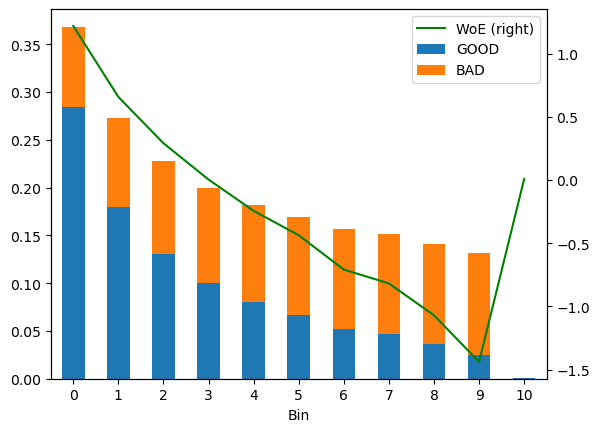

In [46]:
temp = woeDF_include2[woeDF_include2['Variable'] == 'APPS_EXT_SOURCE_MEAN']
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
# 10 la missing : chi co 115 obs => nhom vao nhom cuoi cung
# # NEW_EXTSOURCE_MEAN cang lon thi khach hang cang bad 

## EXT_SOURCE_3

In [47]:
woeDF_include2[woeDF_include2['Variable'] == 'EXT_SOURCE_3']

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,EXT_SOURCE_3,"(-0.000473, 0.228]",24701,4941.0,0.199033,19760.0,0.069901,1.046394,0.135123
1,EXT_SOURCE_3,"(0.228, 0.33]",24744,3156.0,0.127130,21588.0,0.076367,0.509653,0.025871
2,EXT_SOURCE_3,"(0.33, 0.408]",25057,2383.0,0.095992,22674.0,0.080209,0.179627,0.002835
3,EXT_SOURCE_3,"(0.408, 0.476]",24689,1970.0,0.079355,22719.0,0.080368,-0.012683,0.000013
4,EXT_SOURCE_3,"(0.476, 0.535]",24186,1494.0,0.060181,22692.0,0.080273,-0.288070,0.005788
5,EXT_SOURCE_3,"(0.535, 0.592]",25392,1357.0,0.054663,24035.0,0.085024,-0.441749,0.013412
6,EXT_SOURCE_3,"(0.592, 0.643]",24725,1173.0,0.047251,23552.0,0.083315,-0.567161,0.020454
7,EXT_SOURCE_3,"(0.643, 0.694]",24745,1043.0,0.042014,23702.0,0.083846,-0.690973,0.028904
8,EXT_SOURCE_3,"(0.694, 0.749]",23675,836.0,0.033676,22839.0,0.080793,-0.875111,0.041233
9,EXT_SOURCE_3,"(0.749, 0.896]",24632,795.0,0.032024,23837.0,0.084323,-0.968167,0.050634


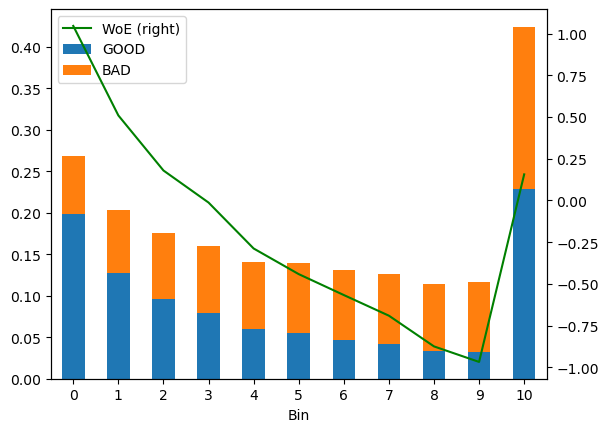

In [48]:
temp = woeDF_include2[woeDF_include2['Variable'] == 'EXT_SOURCE_3']
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
# Missing la tot


## EXT_SOURCE_2

In [49]:
temp3 = woeDF_include2[woeDF_include2['Variable'] == 'EXT_SOURCE_2']
temp3

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,EXT_SOURCE_2,"(-0.0009999404, 0.216]",30694,5631.0,0.226828,25063.0,0.088660,0.939380,0.129792
1,EXT_SOURCE_2,"(0.216, 0.34]",30710,3711.0,0.149486,26999.0,0.095509,0.447987,0.024181
2,EXT_SOURCE_2,"(0.34, 0.44]",30681,3054.0,0.123021,27627.0,0.097730,0.230144,0.005821
3,EXT_SOURCE_2,"(0.44, 0.512]",30787,2571.0,0.103565,28216.0,0.099814,0.036891,0.000138
4,EXT_SOURCE_2,"(0.512, 0.566]",30696,2279.0,0.091803,28417.0,0.100525,-0.090765,0.000792
5,EXT_SOURCE_2,"(0.566, 0.608]",30760,2044.0,0.082336,28716.0,0.101583,-0.210060,0.004043
6,EXT_SOURCE_2,"(0.608, 0.646]",30754,1798.0,0.072427,28956.0,0.102432,-0.346617,0.010400
7,EXT_SOURCE_2,"(0.646, 0.682]",30679,1493.0,0.060141,29186.0,0.103245,-0.540416,0.023294
8,EXT_SOURCE_2,"(0.682, 0.722]",30656,1290.0,0.051964,29366.0,0.103882,-0.692710,0.035964
9,EXT_SOURCE_2,"(0.722, 0.855]",30434,902.0,0.036334,29532.0,0.104469,-1.056130,0.071959


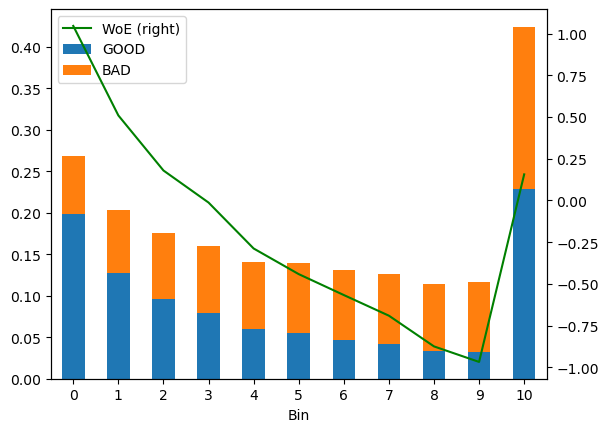

In [50]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## EXT_SOURCE_1


In [51]:
temp = woeDF_include2[woeDF_include2['Variable'] == 'EXT_SOURCE_1']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,EXT_SOURCE_1,"(0.013600000000000001, 0.213]",13425,2358.0,0.094985,11067.0,0.039149,0.886332,0.049489
1,EXT_SOURCE_1,"(0.213, 0.296]",13403,1553.0,0.062558,11850.0,0.041919,0.400346,0.008263
2,EXT_SOURCE_1,"(0.296, 0.369]",13469,1220.0,0.049144,12249.0,0.043331,0.125892,0.000732
3,EXT_SOURCE_1,"(0.369, 0.438]",13366,1124.0,0.045277,12242.0,0.043306,0.044507,0.000088
4,EXT_SOURCE_1,"(0.438, 0.506]",13421,899.0,0.036213,12522.0,0.044296,-0.201474,0.001629
5,EXT_SOURCE_1,"(0.506, 0.573]",13460,808.0,0.032548,12652.0,0.044756,-0.318523,0.003889
6,EXT_SOURCE_1,"(0.573, 0.641]",13439,693.0,0.027915,12746.0,0.045089,-0.479457,0.008234
7,EXT_SOURCE_1,"(0.641, 0.71]",13349,585.0,0.023565,12764.0,0.045153,-0.650287,0.014038
8,EXT_SOURCE_1,"(0.71, 0.787]",13416,470.0,0.018933,12946.0,0.045796,-0.883324,0.023729
9,EXT_SOURCE_1,"(0.787, 0.963]",13385,344.0,0.013857,13041.0,0.046132,-1.202726,0.038819


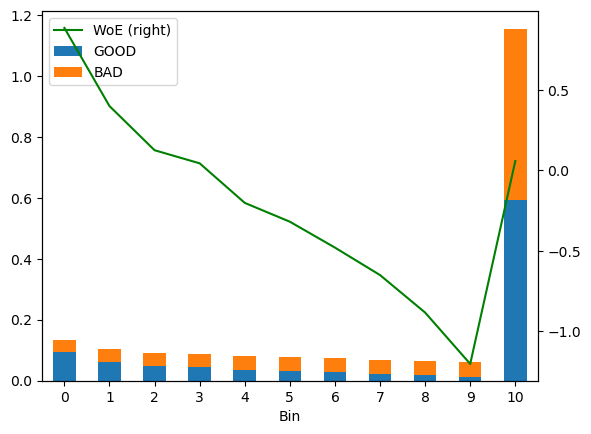

In [52]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN

In [53]:
temp = woeDF_include2[woeDF_include2['Variable'] == 'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(-inf, 0.0]",69538,3854.0,0.155247,65684.0,0.232357,-0.403258,0.031095
1,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.0, 0.0375]",5904,252.0,0.010151,5652.0,0.019994,-0.677850,0.006672
2,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.0375, 0.125]",25147,1199.0,0.048298,23948.0,0.084716,-0.561911,0.020464
3,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.125, 0.189]",25148,1442.0,0.058087,23706.0,0.083860,-0.367212,0.009464
4,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.189, 0.252]",25147,1699.0,0.068439,23448.0,0.082947,-0.192260,0.002789
5,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.252, 0.33]",25147,2062.0,0.083061,23085.0,0.081663,0.016979,0.000024
6,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.33, 0.44]",25147,2454.0,0.098852,22693.0,0.080276,0.208148,0.003866
7,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.44, 0.617]",25147,2974.0,0.119799,22173.0,0.078437,0.423518,0.017517
8,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.617, inf]",25148,3485.0,0.140383,21663.0,0.076633,0.605348,0.038591
9,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,Missing,56038,5404.0,0.217684,50634.0,0.179117,0.195002,0.007520


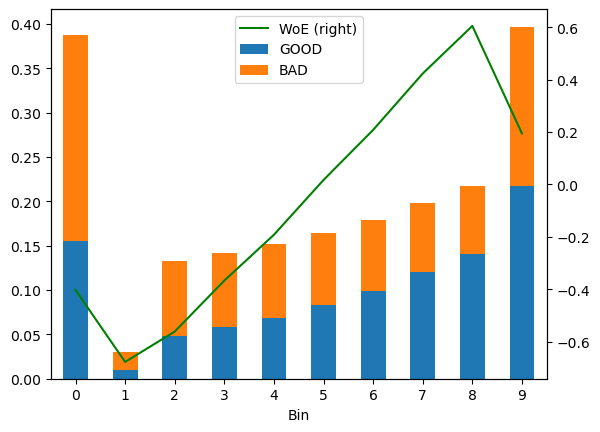

In [54]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

In [55]:
temp = woeDF[woeDF['Variable'] == 'BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN']
temp['Bin']= [i for i in range(temp.shape[0])] 
temp.loc[9, 'Bin'] = -1
temp = temp.sort_values(by = ['Bin'])
temp = temp.reset_index().drop(columns = ['index'])
temp['Bin'] = [i for i in range(temp.shape[0])] 
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV,Bin
0,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,Missing,38012,3654.0,0.216983,34358.0,0.178699,0.194116,0.007432,0
1,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(-inf, 0.0]",47343,2652.0,0.157482,44691.0,0.232442,-0.389330,0.029184,1
2,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.0, 0.0368]",3986,184.0,0.010926,3802.0,0.019775,-0.593219,0.005249,2
3,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.0368, 0.125]",17109,806.0,0.047862,16303.0,0.084794,-0.571893,0.021121,3
4,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.125, 0.189]",17110,946.0,0.056176,16164.0,0.084071,-0.403171,0.011246,4
5,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.189, 0.253]",17109,1160.0,0.068884,15949.0,0.082952,-0.185848,0.002615,5
6,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.253, 0.33]",17109,1439.0,0.085451,15670.0,0.081501,0.047328,0.000187,6
7,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.33, 0.44]",17110,1621.0,0.096259,15489.0,0.080560,0.178041,0.002795,7
8,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.44, 0.619]",17109,1998.0,0.118646,15111.0,0.078594,0.411852,0.016496,8
9,BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN,"(0.619, inf]",17110,2380.0,0.141330,14730.0,0.076612,0.612342,0.039630,9


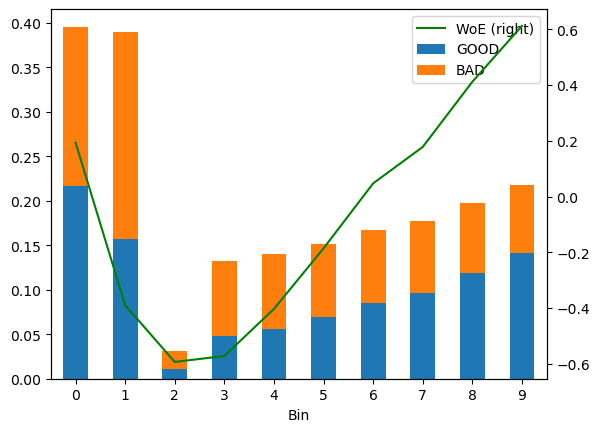

In [56]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()
## Cut off tai diem 0

## BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x

In [57]:
temp = woeDF_include2[woeDF_include2['Variable'] == 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(-inf, 0.0124]",20328,1028.0,0.041410,19300.0,0.068274,-0.500004,0.013432
1,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.0124, 0.429]",20327,1002.0,0.040363,19325.0,0.068362,-0.526916,0.014753
2,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.429, 0.653]",20328,1021.0,0.041128,19307.0,0.068298,-0.507200,0.013781
3,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.653, 0.786]",20329,1160.0,0.046727,19169.0,0.067810,-0.372389,0.007851
4,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.786, 0.867]",20326,1372.0,0.055267,18954.0,0.067050,-0.193260,0.002277
5,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.867, 0.922]",20327,1555.0,0.062638,18772.0,0.066406,-0.058405,0.000220
6,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.922, 0.956]",20327,1920.0,0.077341,18407.0,0.065115,0.172080,0.002104
7,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.956, 0.988]",20336,2204.0,0.088781,18132.0,0.064142,0.325081,0.008010
8,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(0.988, 1.003]",20325,2289.0,0.092205,18036.0,0.063802,0.368231,0.010459
9,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x,"(1.003, inf]",20322,3242.0,0.130594,17080.0,0.060420,0.770768,0.054088


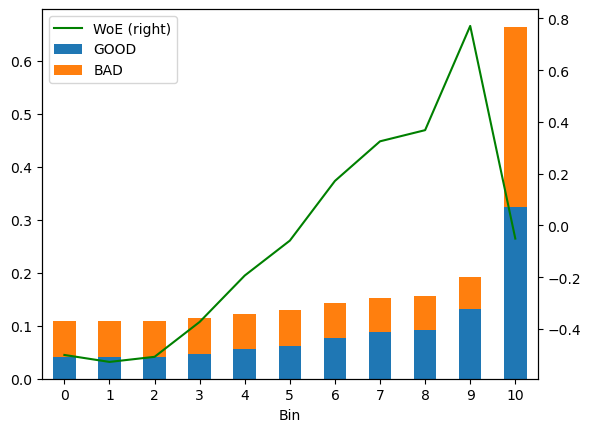

In [58]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y

In [59]:
# BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y
temp = woeDF_include2[woeDF_include2['Variable'] == 'BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(-inf, 0.0]",41470,2186.0,0.088056,39284.0,0.138967,-0.456258,0.023228
1,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.0, 0.467]",18162,981.0,0.039517,17181.0,0.060778,-0.430501,0.009153
2,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.467, 0.702]",19877,1112.0,0.044794,18765.0,0.066381,-0.393348,0.008491
3,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.702, 0.82]",19878,1306.0,0.052608,18572.0,0.065698,-0.222201,0.002909
4,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.82, 0.89]",19877,1499.0,0.060383,18378.0,0.065012,-0.073871,0.000342
5,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.89, 0.937]",19877,1743.0,0.070211,18134.0,0.064149,0.090305,0.000547
6,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.937, 0.972]",19877,2197.0,0.088499,17680.0,0.062543,0.347144,0.009011
7,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(0.972, 1.0]",24528,2829.0,0.113958,21699.0,0.076760,0.395143,0.014698
8,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,"(1.0, inf]",15227,2663.0,0.107271,12564.0,0.044445,0.881103,0.055356
9,BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y,Missing,108738,8309.0,0.334703,100429.0,0.355267,-0.059626,0.001226


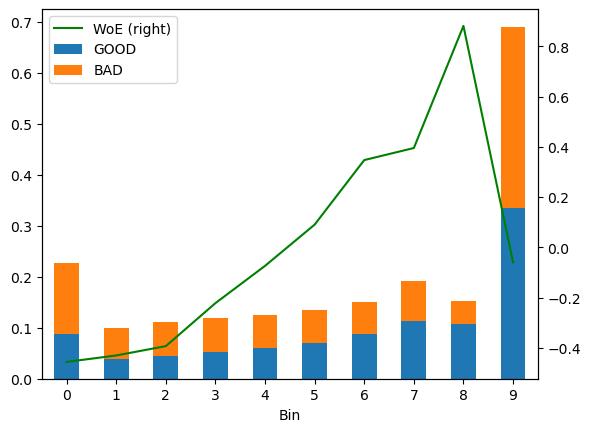

In [60]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## DAYS_EMPLOYED

In [61]:
# DAYS_EMPLOYED
temp = woeDF_include2[woeDF_include2['Variable'] == 'DAYS_EMPLOYED']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,DAYS_EMPLOYED,"(-17912.001, -4881.0]",30754,1464.0,0.058973,29290.0,0.103613,-0.563588,0.025159
1,DAYS_EMPLOYED,"(-4881.0, -3231.0]",30762,1843.0,0.074240,28919.0,0.102301,-0.320619,0.008997
2,DAYS_EMPLOYED,"(-3231.0, -2362.0]",30766,2211.0,0.089063,28555.0,0.101013,-0.125902,0.001504
3,DAYS_EMPLOYED,"(-2362.0, -1695.0]",30740,2546.0,0.102558,28194.0,0.099736,0.027900,0.000079
4,DAYS_EMPLOYED,"(-1695.0, -1213.0]",30800,2972.0,0.119718,27828.0,0.098441,0.195678,0.004163
5,DAYS_EMPLOYED,"(-1213.0, -822.0]",30690,3219.0,0.129668,27471.0,0.097178,0.288425,0.009371
6,DAYS_EMPLOYED,"(-822.0, -458.0]",30771,3475.0,0.139980,27296.0,0.096559,0.371340,0.016124
7,DAYS_EMPLOYED,"(-458.0, -144.0]",30803,3475.0,0.139980,27328.0,0.096673,0.370168,0.016031
8,DAYS_EMPLOYED,"(-144.0, 365243.0]",61425,3620.0,0.145821,57805.0,0.204485,-0.338116,0.019835


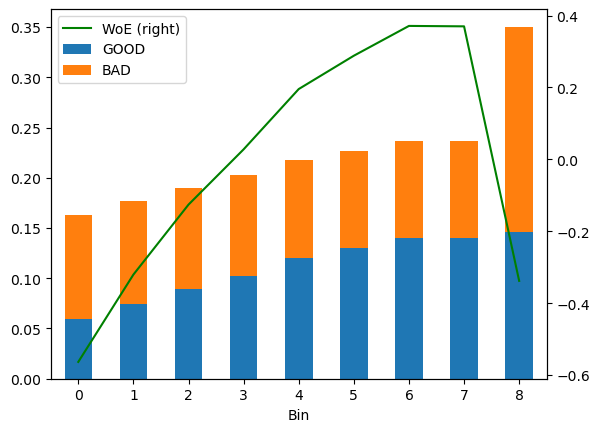

In [62]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## APPS_ANNUITY_CREDIT_RATIO

In [63]:
# APPS_ANNUITY_CREDIT_RATIO
temp = woeDF_include2[woeDF_include2['Variable'] == 'APPS_ANNUITY_CREDIT_RATIO']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,APPS_ANNUITY_CREDIT_RATIO,"(0.0211, 0.0294]",31073,1836.0,0.073958,29237.0,0.103426,-0.335360,0.009882
1,APPS_ANNUITY_CREDIT_RATIO,"(0.0294, 0.0332]",30463,2158.0,0.086928,28305.0,0.100129,-0.141371,0.001866
2,APPS_ANNUITY_CREDIT_RATIO,"(0.0332, 0.0397]",31107,2265.0,0.091239,28842.0,0.102028,-0.111772,0.001206
3,APPS_ANNUITY_CREDIT_RATIO,"(0.0397, 0.0454]",30361,1533.0,0.061752,28828.0,0.101979,-0.501635,0.020179
4,APPS_ANNUITY_CREDIT_RATIO,"(0.0454, 0.05]",56626,5513.0,0.222075,51113.0,0.180812,0.205556,0.008482
5,APPS_ANNUITY_CREDIT_RATIO,"(0.05, 0.0512]",5133,466.0,0.018771,4667.0,0.016509,0.128399,0.000290
6,APPS_ANNUITY_CREDIT_RATIO,"(0.0512, 0.0563]",30493,3012.0,0.121329,27481.0,0.097214,0.221595,0.005344
7,APPS_ANNUITY_CREDIT_RATIO,"(0.0563, 0.0684]",30745,3077.0,0.123948,27668.0,0.097875,0.236164,0.006157
8,APPS_ANNUITY_CREDIT_RATIO,"(0.0684, 0.0951]",30758,3478.0,0.140101,27280.0,0.096503,0.372789,0.016253
9,APPS_ANNUITY_CREDIT_RATIO,"(0.0951, 0.124]",30740,1487.0,0.059899,29253.0,0.103482,-0.546736,0.023828


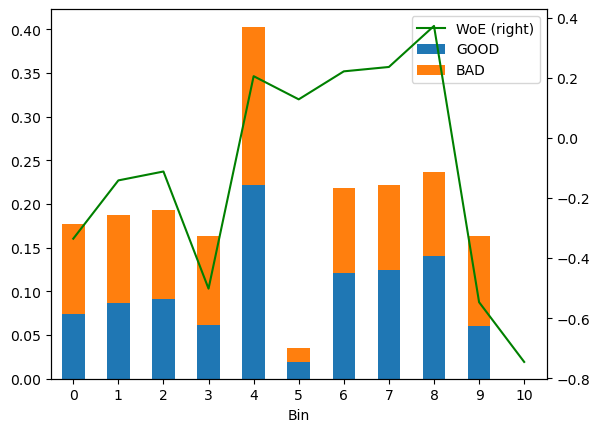

In [64]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## DAYS_BIRTH

In [65]:
# DAYS_BIRTH
temp = woeDF_include2[woeDF_include2['Variable'] == 'DAYS_BIRTH']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,DAYS_BIRTH,"(-25229.001, -22181.0]",30757,1508.0,0.060745,29249.0,0.103468,-0.532576,0.022753
1,DAYS_BIRTH,"(-22181.0, -20474.0]",30756,1668.0,0.067190,29088.0,0.102899,-0.426215,0.015219
2,DAYS_BIRTH,"(-20474.0, -18885.0]",30757,1950.0,0.078550,28807.0,0.101905,-0.260304,0.006079
3,DAYS_BIRTH,"(-18885.0, -17220.0]",30741,2194.0,0.088379,28547.0,0.100985,-0.133340,0.001681
4,DAYS_BIRTH,"(-17220.0, -15750.0]",30761,2397.0,0.096556,28364.0,0.100337,-0.038417,0.000145
5,DAYS_BIRTH,"(-15750.0, -14416.0]",30756,2434.0,0.098046,28322.0,0.100189,-0.021617,0.000046
6,DAYS_BIRTH,"(-14416.0, -13140.0]",30740,2721.0,0.109607,28019.0,0.099117,0.100602,0.001055
7,DAYS_BIRTH,"(-13140.0, -11694.0]",30755,3015.0,0.121450,27740.0,0.098130,0.213210,0.004972
8,DAYS_BIRTH,"(-11694.0, -10284.0]",30764,3380.0,0.136153,27384.0,0.096871,0.340402,0.013372
9,DAYS_BIRTH,"(-10284.0, -7489.0]",30724,3558.0,0.143323,27166.0,0.096100,0.399718,0.018876


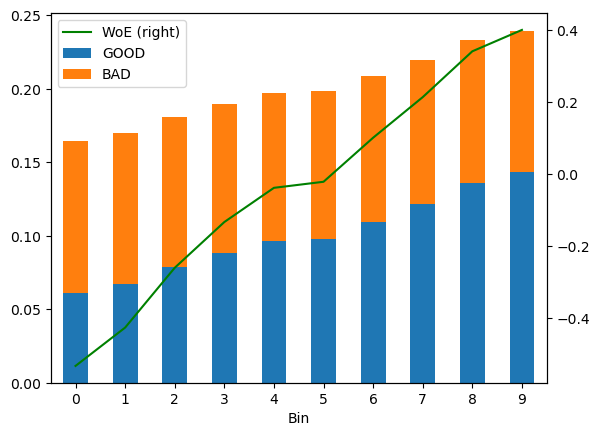

In [66]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## CARD_M3BALANCE_LIMIT_RATIO_MAX

In [67]:
# CARD_M3BALANCE_LIMIT_RATIO_MAX
temp = woeDF_include2[woeDF_include2['Variable'] == 'CARD_M3BALANCE_LIMIT_RATIO_MAX']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(-0.001, 0.466]",39395,2240.0,0.090232,37155.0,0.131436,-0.376137,0.015498
1,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(0.466, 0.89]",6565,518.0,0.020866,6047.0,0.021391,-0.024857,0.000013
2,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(0.89, 0.989]",6566,841.0,0.033877,5725.0,0.020252,0.514479,0.007010
3,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(0.989, 1.035]",6566,1050.0,0.042296,5516.0,0.019513,0.773623,0.017626
4,CARD_M3BALANCE_LIMIT_RATIO_MAX,"(1.035, inf]",6566,1362.0,0.054864,5204.0,0.018409,1.092012,0.039809
5,CARD_M3BALANCE_LIMIT_RATIO_MAX,Missing,241853,18814.0,0.757865,223039.0,0.788999,-0.040260,0.001253


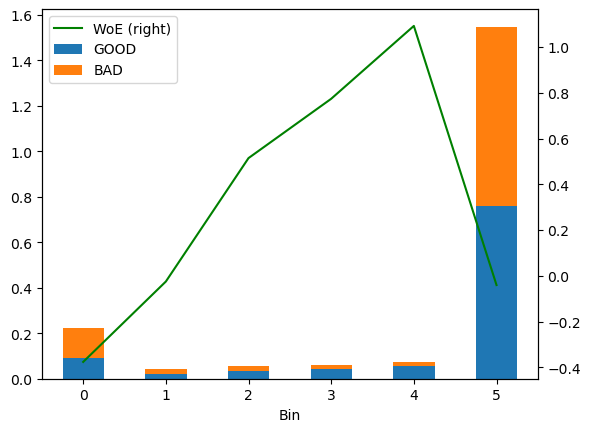

In [68]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## INS_D365SK_DPD_MAX

In [69]:
# INS_D365SK_DPD_MAX
temp = woeDF_include2[woeDF_include2['Variable'] == 'INS_D365SK_DPD_MAX']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,INS_D365SK_DPD_MAX,"(-325.001, -12.0]",22071,1336.0,0.053817,20735.0,0.073350,-0.309657,0.006049
1,INS_D365SK_DPD_MAX,"(-12.0, -8.0]",22169,1333.0,0.053696,20836.0,0.073707,-0.316765,0.006339
2,INS_D365SK_DPD_MAX,"(-8.0, -4.0]",26036,1662.0,0.066949,24374.0,0.086223,-0.253010,0.004877
3,INS_D365SK_DPD_MAX,"(-4.0, -2.0]",18219,1197.0,0.048218,17022.0,0.060215,-0.222203,0.002666
4,INS_D365SK_DPD_MAX,"(-2.0, 0.0]",64411,4628.0,0.186425,59783.0,0.211482,-0.126111,0.003160
5,INS_D365SK_DPD_MAX,"(0.0, 2.0]",22130,2091.0,0.084230,20039.0,0.070888,0.172448,0.002301
6,INS_D365SK_DPD_MAX,"(2.0, 5.0]",19602,2139.0,0.086163,17463.0,0.061775,0.332740,0.008115
7,INS_D365SK_DPD_MAX,"(5.0, 2884.0]",21235,3225.0,0.129909,18010.0,0.063710,0.712491,0.047166
8,INS_D365SK_DPD_MAX,Missing,91638,7214.0,0.290594,84424.0,0.298649,-0.027343,0.000220


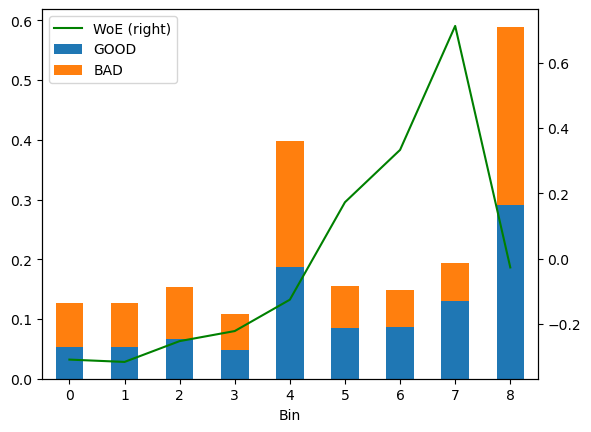

In [70]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## APPS_GOODS_CREDIT_RATIO

In [71]:
# APPS_INCOME_EMPLOYED_RATIO
temp = woeDF_include2[woeDF_include2['Variable'] == 'APPS_GOODS_CREDIT_RATIO']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,APPS_GOODS_CREDIT_RATIO,"(0.166, 0.783]",31047,3895.0,0.156898,27152.0,0.096050,0.490729,0.029860
1,APPS_GOODS_CREDIT_RATIO,"(0.783, 0.826]",31619,3474.0,0.139940,28145.0,0.099563,0.340422,0.013745
2,APPS_GOODS_CREDIT_RATIO,"(0.826, 0.856]",29504,2666.0,0.107392,26838.0,0.094939,0.123246,0.001535
3,APPS_GOODS_CREDIT_RATIO,"(0.856, 0.873]",32162,2735.0,0.110171,29427.0,0.104098,0.056704,0.000344
4,APPS_GOODS_CREDIT_RATIO,"(0.873, 0.894]",33279,2214.0,0.089184,31065.0,0.109892,-0.208795,0.004324
5,APPS_GOODS_CREDIT_RATIO,"(0.894, 0.927]",26948,1821.0,0.073353,25127.0,0.088887,-0.192072,0.002983
6,APPS_GOODS_CREDIT_RATIO,"(0.927, 1.0]",122414,7986.0,0.321692,114428.0,0.404788,-0.229770,0.019093
7,APPS_GOODS_CREDIT_RATIO,"(1.0, 6.667]",260,13.0,0.000524,247.0,0.000874,-0.511953,0.000179
8,APPS_GOODS_CREDIT_RATIO,Missing,278,21.0,0.000846,257.0,0.000909,-0.072068,0.000005


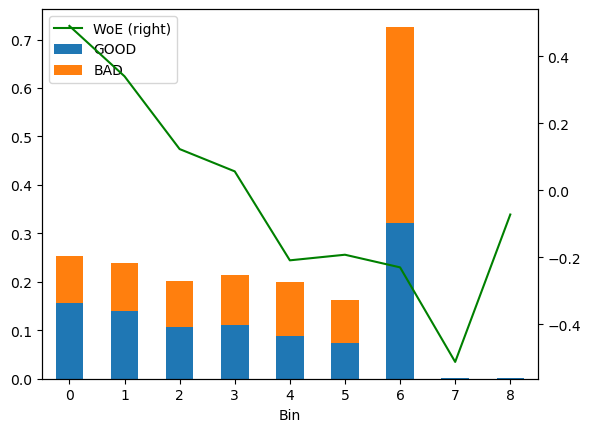

In [72]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## PREV_REFUSED_RATIO

In [73]:
# PREV_REFUSED_RATIO
temp = woeDF_include2[woeDF_include2['Variable'] == 'PREV_REFUSED_RATIO']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,PREV_REFUSED_RATIO,"(-0.001, 0.143]",206507,14639.0,0.589688,191868.0,0.678732,-0.140633,0.012523
1,PREV_REFUSED_RATIO,"(0.143, 0.25]",31260,2679.0,0.107915,28581.0,0.101105,0.065187,0.000444
2,PREV_REFUSED_RATIO,"(0.25, 0.4]",26320,2797.0,0.112669,23523.0,0.083212,0.303054,0.008927
3,PREV_REFUSED_RATIO,"(0.4, 1.0]",26577,3709.0,0.149406,22868.0,0.080895,0.613509,0.042032
4,PREV_REFUSED_RATIO,Missing,16847,1001.0,0.040322,15846.0,0.056055,-0.329432,0.005183


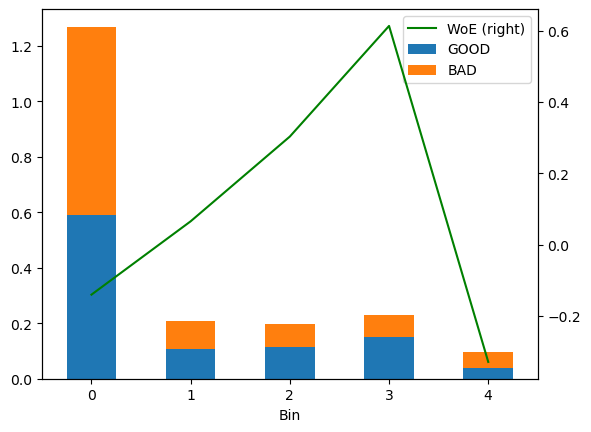

In [74]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## INS_INS_IS_DPD_UNDER_120_MEAN

In [75]:
# INS_INS_IS_DPD_UNDER_120_MEAN
temp = woeDF_include2[woeDF_include2['Variable'] == 'INS_INS_IS_DPD_UNDER_120_MEAN']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,INS_INS_IS_DPD_UNDER_120_MEAN,"(-0.001, 0.0175]",145871,9825.0,0.395770,136046.0,0.481262,-0.195577,0.016720
1,INS_INS_IS_DPD_UNDER_120_MEAN,"(0.0175, 0.0476]",29688,2160.0,0.087009,27528.0,0.097380,-0.112610,0.001168
2,INS_INS_IS_DPD_UNDER_120_MEAN,"(0.0476, 0.0857]",28865,2463.0,0.099215,26402.0,0.093397,0.060426,0.000352
3,INS_INS_IS_DPD_UNDER_120_MEAN,"(0.0857, 0.143]",30222,2952.0,0.118912,27270.0,0.096467,0.209181,0.004695
4,INS_INS_IS_DPD_UNDER_120_MEAN,"(0.143, 0.237]",27927,2802.0,0.112870,25125.0,0.088880,0.238956,0.005733
5,INS_INS_IS_DPD_UNDER_120_MEAN,"(0.237, 1.0]",29070,3674.0,0.147996,25396.0,0.089838,0.499175,0.029031
6,INS_INS_IS_DPD_UNDER_120_MEAN,Missing,15868,949.0,0.038228,14919.0,0.052776,-0.322497,0.004692


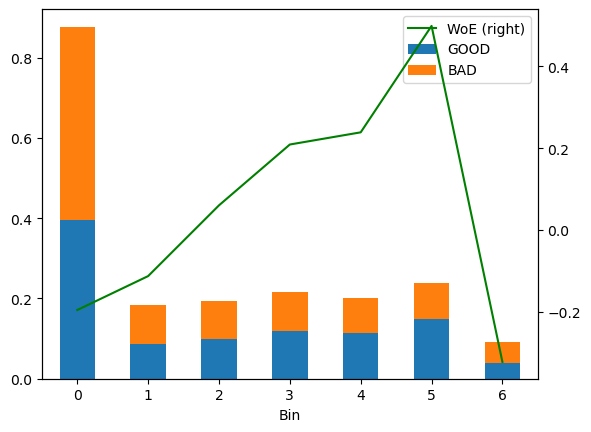

In [76]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## INS_D365AMT_RATIO_MEAN

In [77]:
# NAME_INCOME_TYPE
temp = woeDF_include2[woeDF_include2['Variable'] == 'INS_D365AMT_RATIO_MEAN']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,INS_D365AMT_RATIO_MEAN,"(-0.0009214000000000001, 0.9]",21594,2867.0,0.115488,18727.0,0.066247,0.555785,0.027368
1,INS_D365AMT_RATIO_MEAN,"(0.9, 0.997]",21581,2523.0,0.101631,19058.0,0.067418,0.410447,0.014043
2,INS_D365AMT_RATIO_MEAN,"(0.997, 1.0]",152119,11028.0,0.444230,141091.0,0.499109,-0.116482,0.006392
3,INS_D365AMT_RATIO_MEAN,"(1.0, 3376.3]",20579,1193.0,0.048056,19386.0,0.068578,-0.355594,0.007297
4,INS_D365AMT_RATIO_MEAN,Missing,91638,7214.0,0.290594,84424.0,0.298649,-0.027343,0.000220


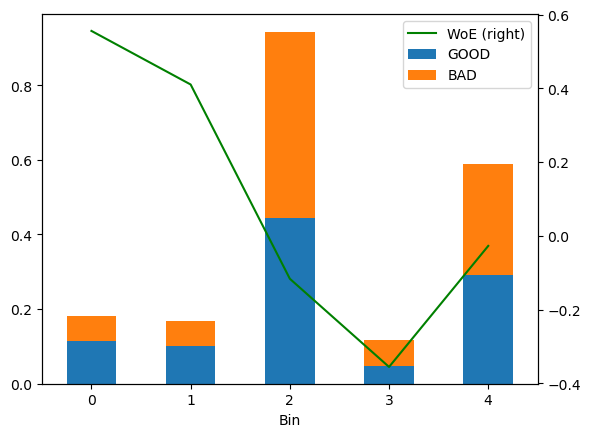

In [78]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()

## REGION_RATING_CLIENT_W_CITY

In [79]:
train['REGION_RATING_CLIENT_W_CITY'].value_counts()

2    156125
3     29691
1     23291
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

In [80]:
# PREV_D365_PREV_INTERESTS_RATE_MAX
temp = woeDF_include2[woeDF_include2['Variable'] == 'REGION_RATING_CLIENT_W_CITY']
temp

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,REGION_RATING_CLIENT_W_CITY,1,34167,1654.0,0.066626,32513.0,0.115015,-0.545958,0.026418
1,REGION_RATING_CLIENT_W_CITY,2,229484,18170.0,0.731923,211314.0,0.747522,-0.021088,0.000329
2,REGION_RATING_CLIENT_W_CITY,3,43860,5001.0,0.201450,38859.0,0.137463,0.382184,0.024455


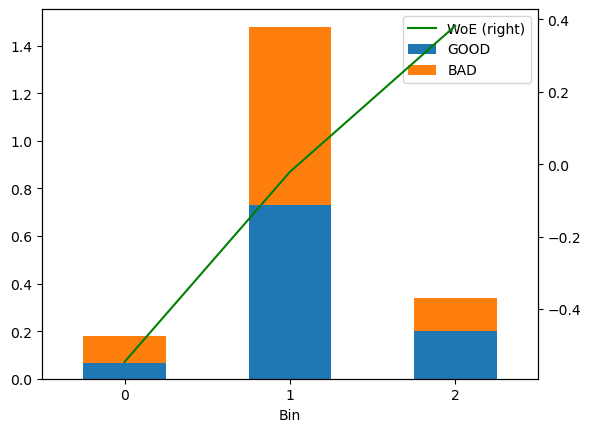

In [81]:
temp['Bin'] = [i for i in range(temp.shape[0])]
temp = temp.rename(columns = {'% of Events': 'GOOD','% of Non-Events': 'BAD'})
ax = temp[['Bin', 'WoE']].plot(x = 'Bin', kind = 'line', 
                                              secondary_y=True, color = 'green')
ax = temp[['GOOD', 'BAD', 'Bin']].set_index('Bin').plot.bar(stacked=True, 
                                                                         ax = ax)
# plt.xticks(rotation = 30)
plt.show()